## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [15]:
import george
from george.kernels import ExpSquaredCenteredKernel, ExpSquaredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
#import warnings
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [43]:
ycounts = np.load("ycounts.npy")
yerrs = np.load("yerrs.npy")
xbins = np.load("xbins.npy")
xerrs = np.load("xerrs.npy")
toyData = np.load("toys.npy")
xlow = list(xbins-xerrs/2.)
fixedHyperparameters = np.load("fixedHyperparameters.npy")

standardParamSets = [(1500,2000,250), (1000 ,2500, 250),(750, 3000, 250), (250, 3500, 250), (100, 4000, 250), 
             (75, 4500, 250), (60, 5000, 250), (50,5500, 250), (35, 6000,250)]

In [6]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerrs):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

In [7]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

In [8]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### This set has all bins that equal 0 removed. These 0 points really bias the GP

## GP SIGNAL FIGURE 8

In [47]:
def makePrettyPlots_sb(x, y_sd, y_d, bkg, bkg_s, xlow, title, ymax = 2e5):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(x, y_sd, marker='o', ls='None', yerr = np.sqrt(y_sd), c='black', markersize=10, label="data+signal")
    bkgPlot_b, = ax1.plot(x, bkg, color='b', linewidth=3.0, label="bkg only")
    bkgPlot_sb, = ax1.plot(x, bkg_s, color='g', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(y_sd, bkg_s)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+sig vs bkg+sig",(1020,3.5), fontsize=15)
    #ax2.set_ylim([-2, 8])

    zvals_2, chi2_2 = calcSignificance(y_sd, bkg)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg",(1020,3.5), fontsize=15)
    
    zvals_3, chi2_3 = calcSignificance(y_d, bkg)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(1020,3.5), fontsize=15)

    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="signal fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [12]:
def model_gp(params, t, xerr=xerrs): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [11]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, length, p0, p1, p2 = fixedHyperparameters
        kernel1 = Amp * ExpSquaredKernel(length)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in sqrt
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 inf


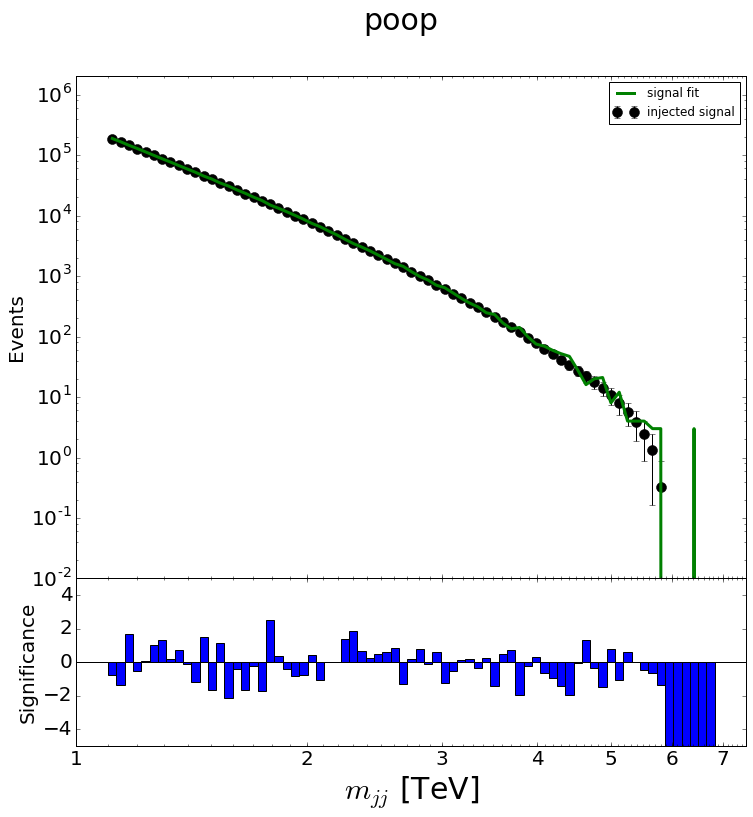

In [49]:
makePrettyPlots_signalOnly(xbins, toyData[0], ycounts, "poop", ymax = 2e6)

parameters (1500, 2000, 250)
0
min LL 339.046737515
best fit vals (23404.10725643472, 2020.4685793358697, 223.21760038822868)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ -7.19311243e-02  -1.19217769e-01  -1.96843186e-01  -3.23477473e-01
  -5.28532400e-01  -8.57692667e-01  -1.38076575e+00  -2.20240648e+00
  -3.47606796e+00  -5.42097738e+00  -8.34083605e+00  -1.26410990e+01
  -1.88390056e+01  -2.75571978e+01  -3.94885121e+01  -5.53178869e+01
  -7.55897042e+01  -1.00518174e+02  -1.29756802e+02  -1.62169989e+02
  -1.95679629e+02  -2.27279491e+02  -2.53302637e+02  -2.69976225e+02
  -2.74202085e+02  -2.64383995e+02  -2.41034955e+02  -2.06901084e+02
  -1.66468169e+02  -1.24944630e+02  -8.70426871e+01  -5.59831190e+01
  -3.30550822e+01  -

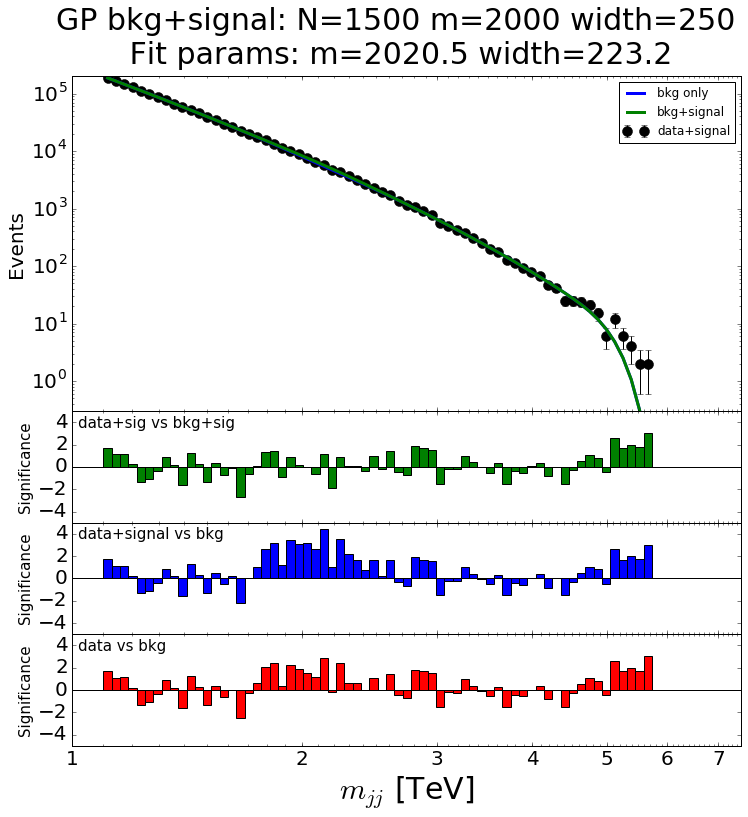

min LL 346.868283759
best fit vals (19435.43498496581, 2100.9923268692037, 105.53029676327724)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.09494702e-13   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.000

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


min LL 357.251645245
best fit vals (50471.44952761148, 2096.066075375887, 143.17884572249216)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.54747351e-13   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.0000

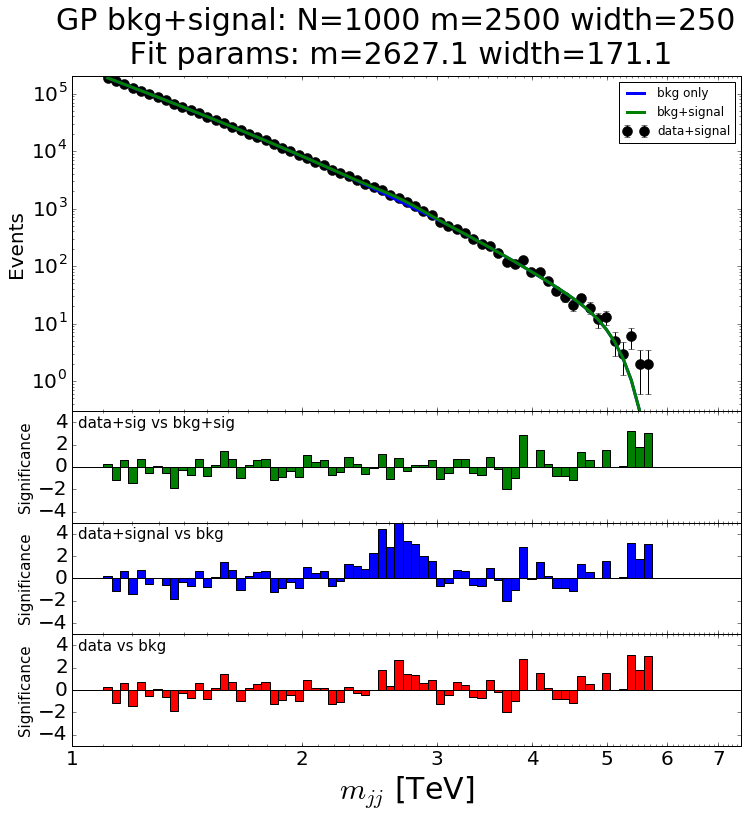

min LL 341.521492744
best fit vals (4950.575773630197, 2518.8621048048835, 296.8297319622593)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ -1.37673967e-03  -2.14900298e-03  -3.36083316e-03  -5.26373056e-03
  -8.25227426e-03  -1.29439579e-02  -2.03019002e-02  -3.18219445e-02
  -4.98151995e-02  -7.78298421e-02  -1.21272285e-01  -1.88307178e-01
  -2.91136216e-01  -4.47772801e-01  -6.84434337e-01  -1.03865128e+00
  -1.56311896e+00  -2.33016317e+00  -3.43641696e+00  -5.00688071e+00
  -7.19695094e+00  -1.01902998e+01  -1.41898099e+01  -1.93983985e+01
  -2.59869430e+01  -3.40481865e+01  -4.35389524e+01  -5.42183311e+01
  -6.55960307e+01  -7.69109237e+01  -8.71618765e+01  -9.52076253e+01
  -9.99373109e+01  -1.00489340e+02  -9.64698355e+01 

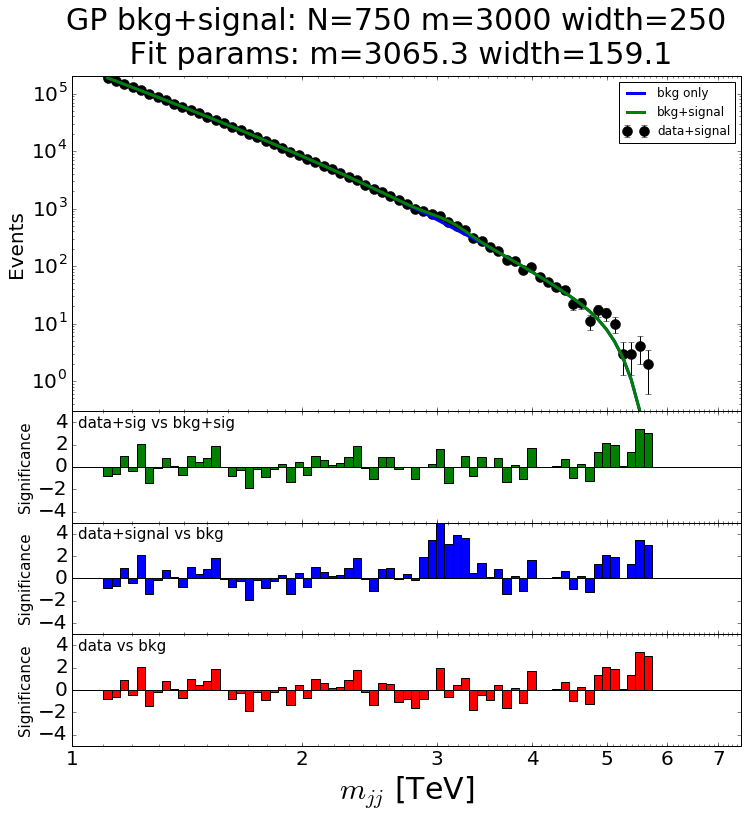

min LL 343.109011313
best fit vals (9096.716492196218, 3067.4349034965653, 264.6817855415253)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -1.13686838e-13   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.0000

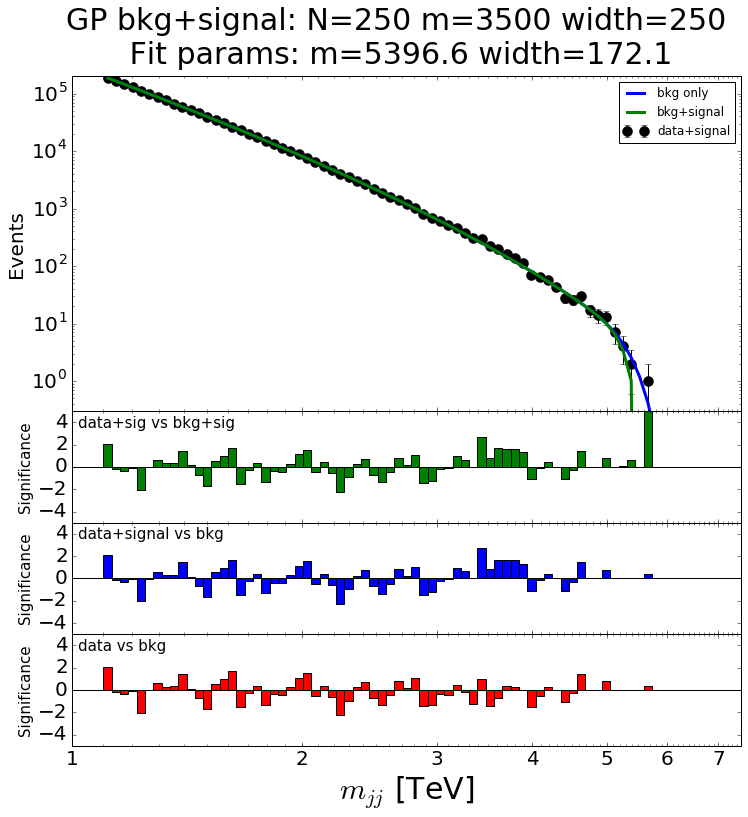

min LL 345.843078544
best fit vals (1588.9866819512836, 3558.831123931231, 240.38230843124032)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.000

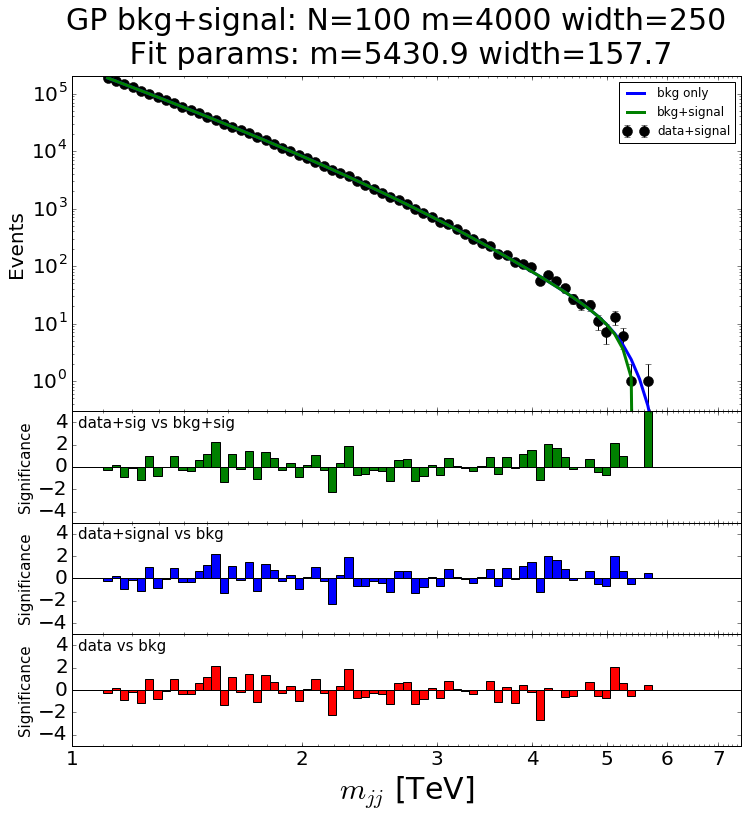

min LL 352.68340424
best fit vals (559.2094174341598, 4047.5355844724613, 149.62319427605928)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

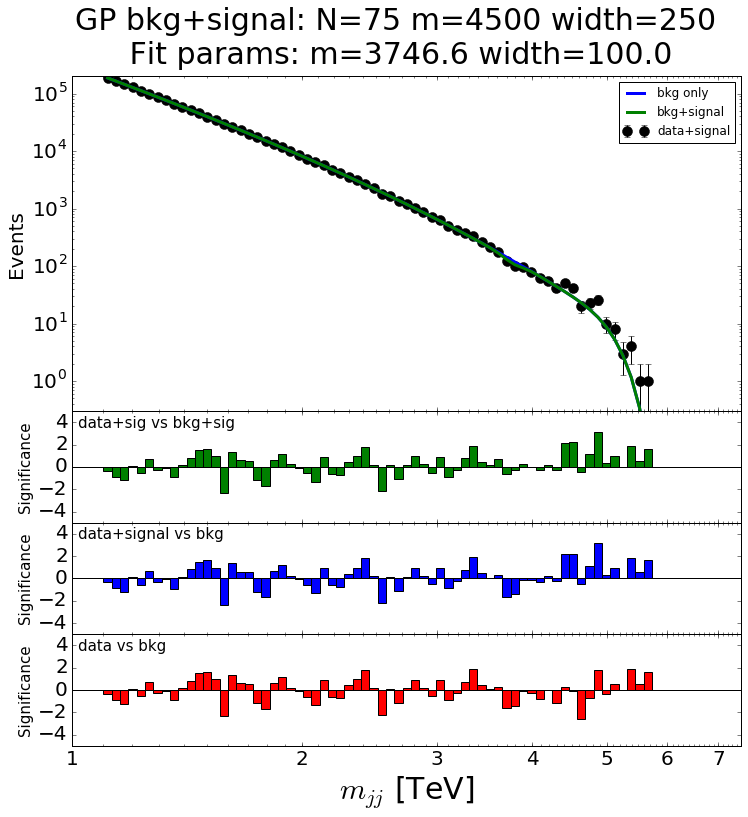

min LL 345.042538586
best fit vals (108.05082626794042, 4492.3251303246325, 347.24743000923604)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00

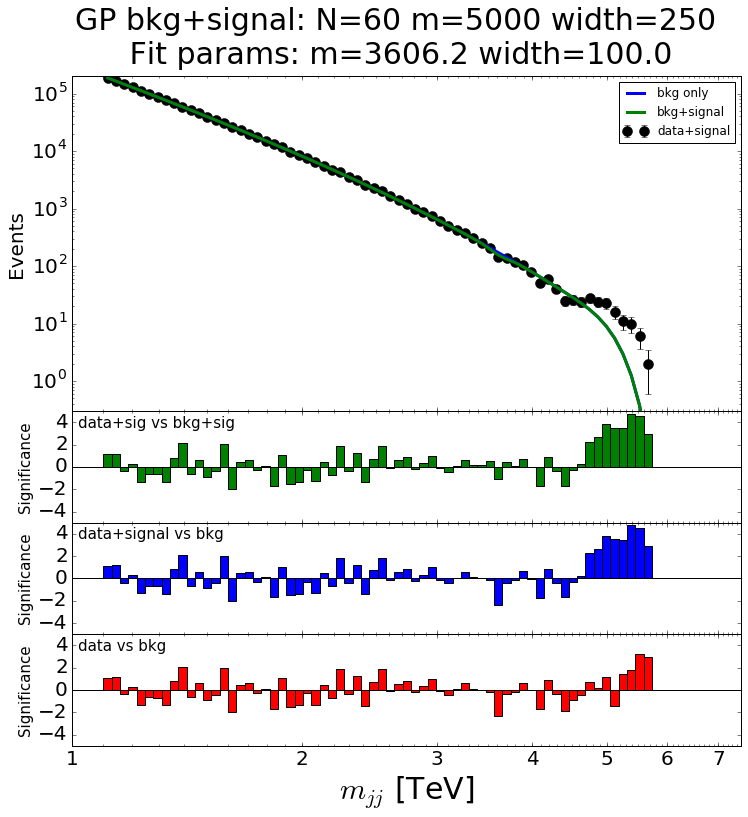

min LL 353.105920393
best fit vals (8.903708989316772, 5851.163567202746, 100.00003433187068)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.0000

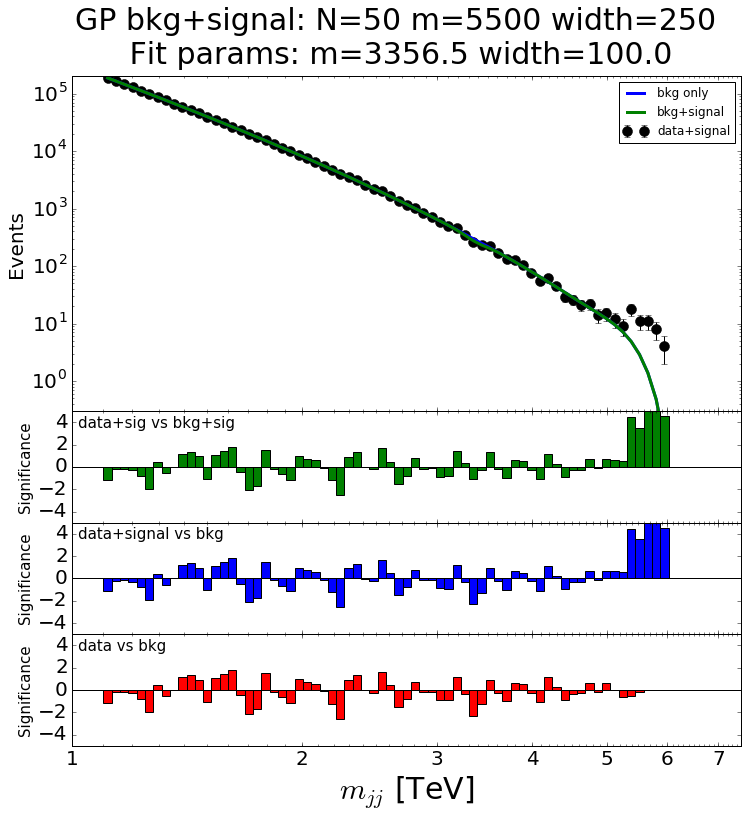

min LL 356.597020988
best fit vals (86.51322408091795, 5464.7019655235235, 100.00055128400764)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00

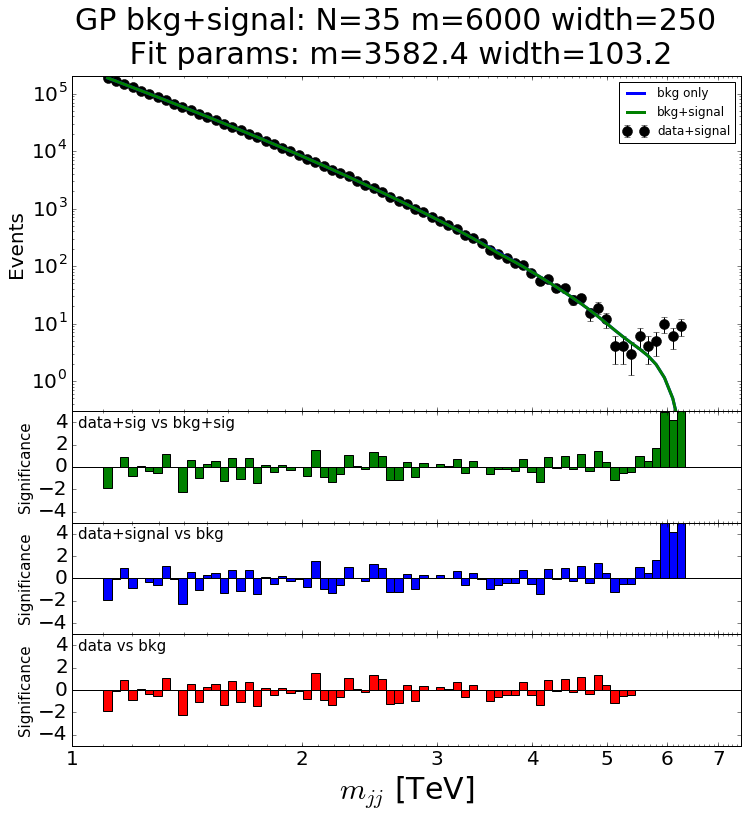

min LL 349.876825479
best fit vals (58.337923937616665, 5995.022795003045, 252.12020661460585)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


In [56]:
chi_GP_sig={}
chi_GP_bkg={}
chi_GP_sb={}
aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig[m]=[]
    chi_GP_bkg[m]=[]
    chi_GP_sb[m]=[]
    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyData[:10]):
        if itoy%10 ==0: print itoy
        toy = np.random.poisson(np.around([0 if t < 0 else t for t in toy]))
        #signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
        #signalTemplate = np.random.poisson(np.around(signalTemplate))
        
        signalTemplate = sig_model(xbins, n, m, w, xerrs)
        signalTemplate = np.random.poisson(np.around(signalTemplate))

        #ydata = ytoy + signalTemplate
        ydata =  toy + signalTemplate
        
        Amp, length, p0, p1, p2 = fixedHyperparameters
        lnProb = logLike_gp_fitgpsig(xbins, ydata, xerrs)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, True)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)

        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * ExpSquaredKernel(length)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp.compute(xbins, np.sqrt(ydata))
        meanGP = gp.predict(ydata, xbins)[0]

        gp2 = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp2.compute(xbins, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xbins).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))+ model_gp((p0,p1, p2), xbins, xerrs)
        K2 = kernel2.get_value(np.atleast_2d(xbins).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata-model_gp((p0,p1, p2), xbins, xerrs)))
        mu1=meanGP-mu2
        #print mu1
        print (mu2+mu1)-meanGP
        print mu1-meanGP
        print mu2-meanGP
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydata, meanGP)
        zvalbkg, chi2bkg = calcSignificance(toy, mu1)
        chi_GP_sig[m].append(chi2sig) 
        chi_GP_sb[m].append(chi2sb) 
        chi_GP_bkg[m].append(chi2bkg) 
        

        if itoy%10 ==0:
            label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
            makePrettyPlots_sb(xbins, ydata, toy, mu1, meanGP, xlow, label)
    
        #label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        #makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

In [57]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

parameters (1500, 2000, 250)
20600.3806461 2012.83034074 262.494915499
parameters (1000, 2500, 250)
11144.9959052 2528.96568709 240.698283859
parameters (750, 3000, 250)
8388.55563589 3034.96882617 227.23557729
parameters (250, 3500, 250)
1219.44728539 3655.72761646 245.730320467
parameters (100, 4000, 250)
1425.69605902 4018.13820839 154.320074338
parameters (75, 4500, 250)
10704.5527729 3676.30467772 143.890825558
parameters (60, 5000, 250)
196.496001399 4990.0436066 224.288028196
parameters (50, 5500, 250)
283.833455929 5045.91677062 154.26487591
parameters (35, 6000, 250)
10180.3785259 4910.96606902 171.162832472
